# <font color='008fd0'>Overview</font>

This notebooks provides a brief visualization of the dataset as well as how great did the model performed.

## <font color='00b269'>Workflow</font>
- **Exploratory Data Analysis**:
    - class imbalance
    - age distribution by class
    - distribution of medical features by class
- **Feature Correlation**: comparison of the correlation between features and classes
    - dataset with groundtruths
    - dataset with predicted classes
- **Model Learning**: $\frac{\partial\  model}{\partial\  feature}$
    - notice how the model probabilities modify as a certain features change
    - age distribution matches dataset distribution
- **Model - Feature Importance**:
    - visualize top 5 features used by each model **(HF, RF, CI)**


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# from Model import BasicTransformations, DateTransformer, MultiOutputClassifier
from utils import BasicTransformations, DateTransformer, MultiOutputClassifier
import pickle
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")
sns.set_palette("viridis")

In [3]:
dir = "../../../Data/Patient/DataSet"

dataset = pd.read_parquet(dir, engine='pyarrow')
target_columns = ['HF', 'RF', 'CI']

dataset = dataset[(dataset['Age'] >= 0) & (dataset['Age'] <= 95)]
dataset['Class'] = dataset[['HF', 'RF', 'CI']].apply(lambda x: x.idxmax() if x.any() else 'None', axis=1)

print(dataset.shape)
dataset.head()


(1566410, 20)


,Date,ID,Sex,Type,Age,HT,AF,CIHD,COPD,VI,HF,RF,CI,Max,Min,Prec,Press,Wind,Insolat,Class
0,2007-02-16,520566,M,Nastere,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
1,2007-02-16,651708,F,Nastere,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
2,2007-02-16,793398,F,Nastere,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
3,2007-02-16,826504,M,Nastere,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None
4,2007-02-16,826506,M,Nastere,0,0,0,0,0,0,0,0,0,8.0,1.5,1.8,1021.4,5,0.0,None


In [4]:

processing = DateTransformer(day='weekend', month=True, holiday=True)
df = processing.transform(dataset)
df['Sex'].replace({'F': 0, 'M': 1}, inplace=True)
df.head()

,ID,Sex,Type,Age,HT,AF,CIHD,COPD,VI,HF,...,Max,Min,Prec,Press,Wind,Insolat,Class,Weekend,Month,Holiday
0,520566,1,Nastere,0,0,0,0,0,0,0,...,8.0,1.5,1.8,1021.4,5,0.0,None,1,2,0
1,651708,0,Nastere,0,0,0,0,0,0,0,...,8.0,1.5,1.8,1021.4,5,0.0,None,1,2,0
2,793398,0,Nastere,0,0,0,0,0,0,0,...,8.0,1.5,1.8,1021.4,5,0.0,None,1,2,0
3,826504,1,Nastere,0,0,0,0,0,0,0,...,8.0,1.5,1.8,1021.4,5,0.0,None,1,2,0
4,826506,1,Nastere,0,0,0,0,0,0,0,...,8.0,1.5,1.8,1021.4,5,0.0,None,1,2,0


In [5]:
model = pickle.load(open('../../Models/Patient.pkl', 'rb'))

In [6]:
predicted = model.predict(dataset.drop(['HF', 'RF', 'CI', 'Class', 'ID', 'Type'], axis=1))
predicted_proba = model.predict_proba(dataset.drop(['HF', 'RF', 'CI', 'Class', 'ID', 'Type'], axis=1))

In [7]:
predicted_targets = [f'{col}_pred' for col in target_columns]
df[predicted_targets] = predicted
df['Class_pred'] = df[predicted_targets].apply(lambda x: x.idxmax() if x.any() else 'None_pred', axis=1)


predicted_proba_targets = [f'{col}_pred_proba' for col in target_columns]
df[predicted_proba_targets] = predicted_proba[:, :, 1].T.round(2)
df.head()

,ID,Sex,Type,Age,HT,AF,CIHD,COPD,VI,HF,...,Weekend,Month,Holiday,HF_pred,RF_pred,CI_pred,Class_pred,HF_pred_proba,RF_pred_proba,CI_pred_proba
0,520566,1,Nastere,0,0,0,0,0,0,0,...,1,2,0,0,1,0,RF_pred,0.05,0.53,0.07
1,651708,0,Nastere,0,0,0,0,0,0,0,...,1,2,0,0,0,0,None_pred,0.05,0.43,0.07
2,793398,0,Nastere,0,0,0,0,0,0,0,...,1,2,0,0,0,0,None_pred,0.05,0.43,0.07
3,826504,1,Nastere,0,0,0,0,0,0,0,...,1,2,0,0,1,0,RF_pred,0.05,0.53,0.07
4,826506,1,Nastere,0,0,0,0,0,0,0,...,1,2,0,0,1,0,RF_pred,0.05,0.53,0.07


## Exploratory Data Analysis

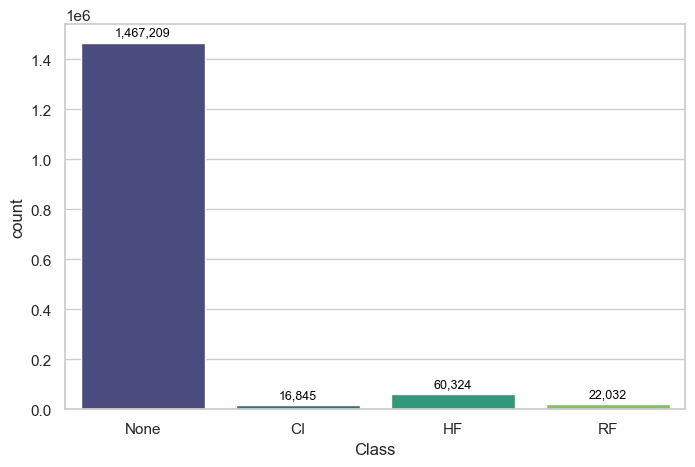

In [10]:
ax = sns.countplot(x='Class', data=df, hue='Class', palette='viridis', figure=plt.figure(figsize=(8, 5)))

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count:,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

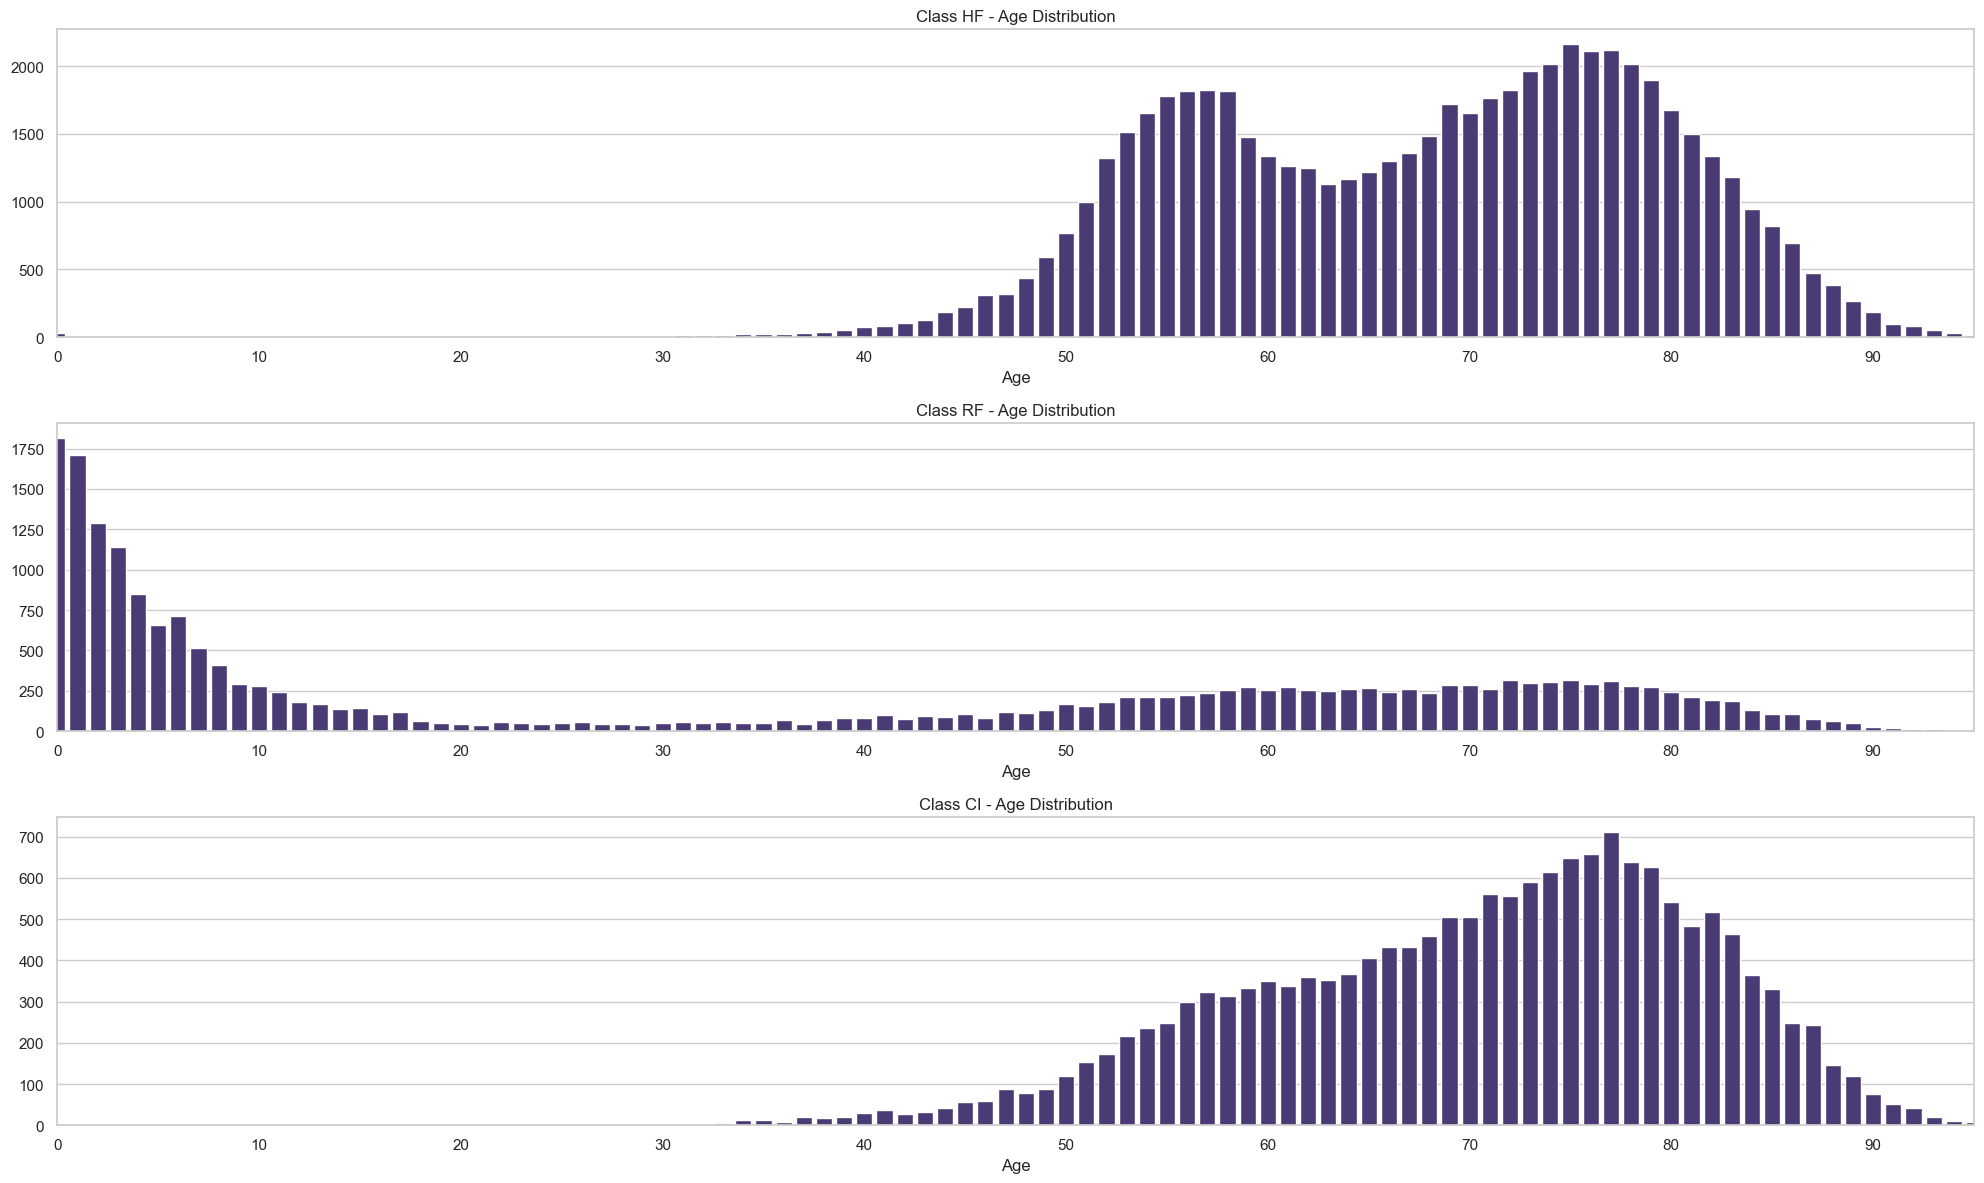

In [9]:
fig, axs = plt.subplots(nrows=len(target_columns), figsize=(20, 4 * len(target_columns)))

for i, class_val in enumerate(target_columns):
    class_data = dataset[dataset['Class'] == class_val]['Age'].value_counts().sort_index()
    class_data = class_data.reindex(range(96), fill_value=0)

    sns.barplot(x=class_data.index, y=class_data.values, ax=axs[i])
    axs[i].set_xticks(range(0, 96, 10))
    axs[i].set_xlim(0, 95)
    axs[i].set_title(f'Class {class_val} - Age Distribution')

plt.tight_layout()
plt.show()

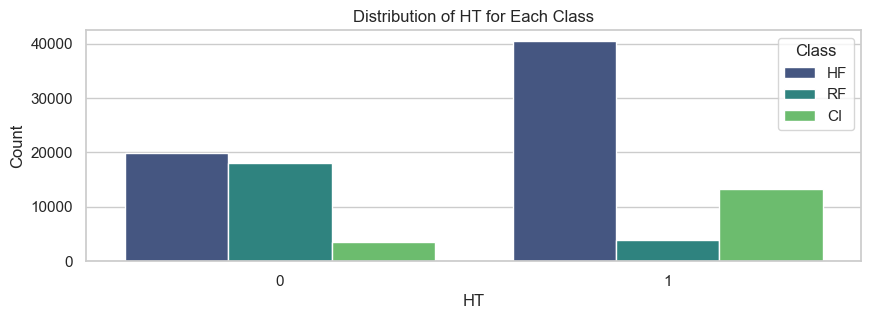

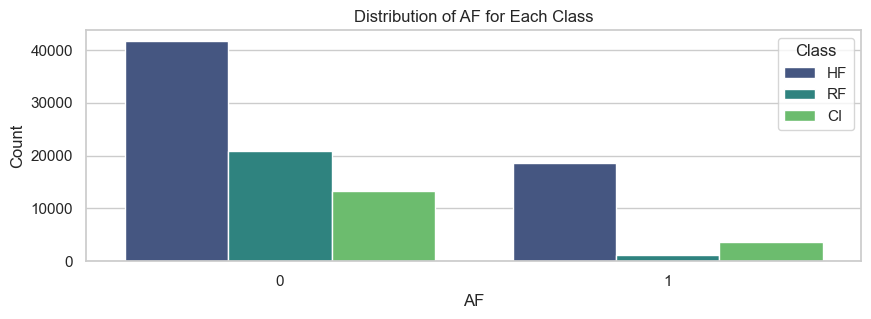

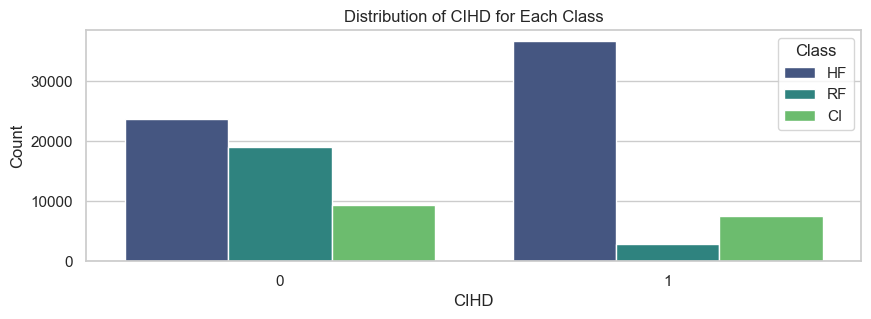

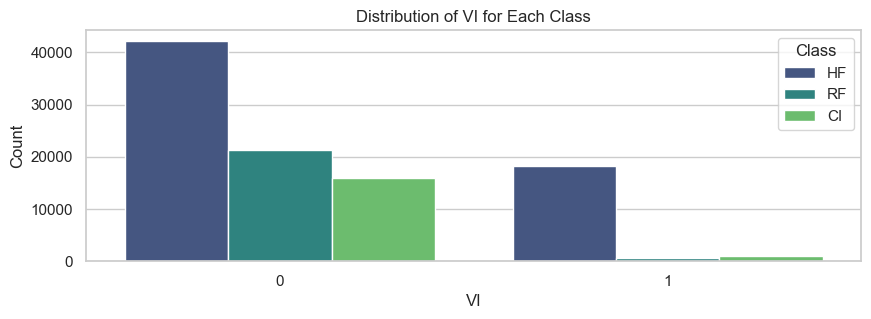

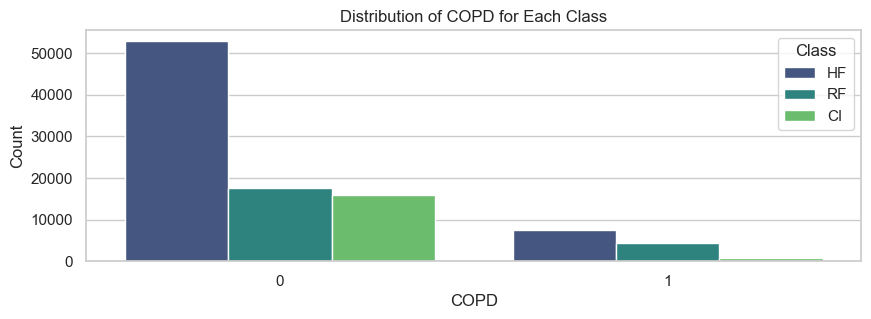

In [98]:
def feature_distribution(df, feature):
    plt.figure(figsize=(10, 3))
    ax = sns.countplot(x=feature, hue='Class', data=df[df['Class'] != 'None'], palette='viridis', hue_order=['HF', 'RF', 'CI'])

    ax.set_title(f'Distribution of {feature} for Each Class')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Count')

    ax.legend(title='Class')
    plt.show()

for feature in ['HT', 'AF', 'CIHD', 'VI', 'COPD']:
    feature_distribution(df, feature)

## Feature Correlation

(0.0, 1.0)

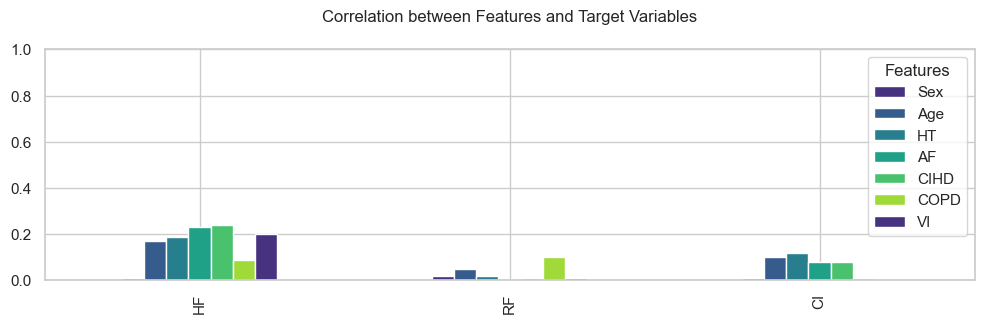

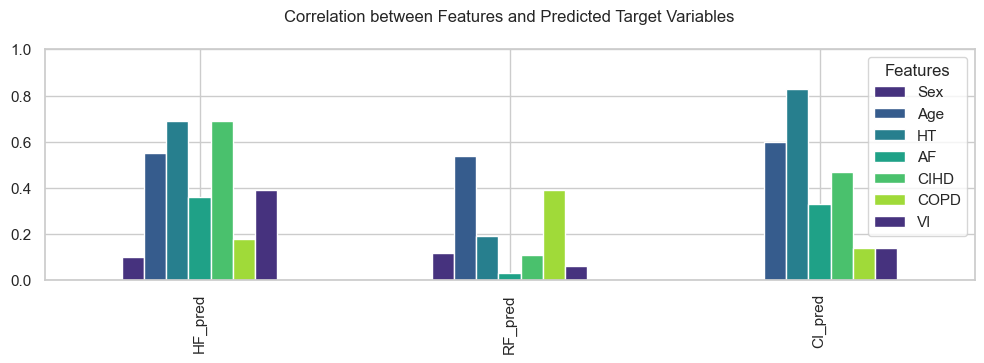

In [13]:
features = ['Sex', 'Age', 'HT','AF','CIHD','COPD','VI']

df[features + target_columns].corr().abs().round(2).loc[target_columns, features].plot(kind='bar', figsize=(12, 3))
plt.title('Correlation between Features and Target Variables', pad=20)
plt.legend(title='Features')
plt.ylim(0, 1)


df[features + predicted_targets].corr().abs().round(2).loc[predicted_targets, features].plot(kind='bar', figsize=(12, 3))
plt.title('Correlation between Features and Predicted Target Variables', pad=20)
plt.legend(title='Features')
plt.ylim(0, 1)

## Model Learning

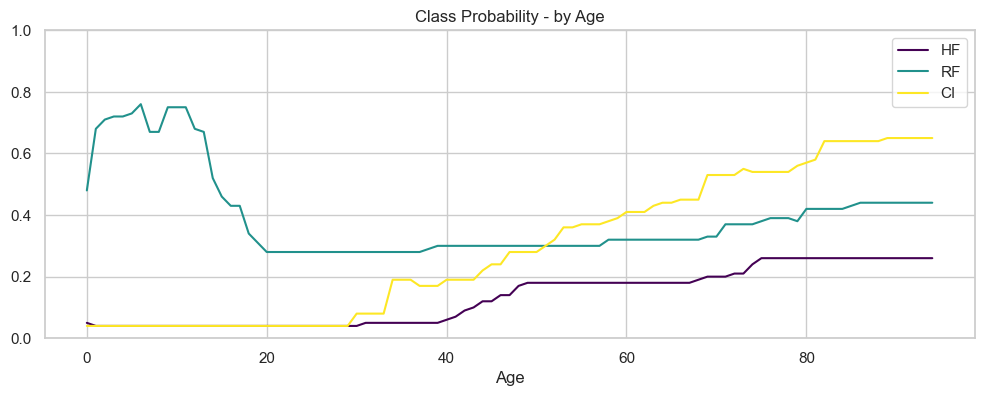

In [ ]:
import datetime
example = {
    'Date': datetime.date(2023, 4, 21),
    'Sex': 'M',
    'Age': 30,
    'HT': 0,
    'AF': 0,
    'CIHD': 0,
    'COPD': 0,
    'VI': 0,
    'Max': 23,
    'Min': 15,
    'Prec': 0,
    'Press': 900,
    'Wind': 4,
    'Insolat': 14
}

def plot_feature_importance(model, column, values=range(2), verbose=True, kind='bar', figsize=(5, 3)):
    results = []

    for i in values:
        example[column] = i
        res = model.predict_proba(pd.DataFrame(example, index=[0]))
        results.append([i] + res[:, :, 1].T.round(2).tolist()[0])
    
    if verbose:
        for i, row in enumerate(np.array(results)[:, 1:].T):
            print(f"{target_columns[i]}: {' -> '.join([str(x.round(2)) for x in row])}")
    
    pd.DataFrame(results, columns=[column] + target_columns)\
        .plot(
            x=column, 
            y=target_columns, 
            ylim=(0, 1),
            kind=kind, 
            grid=True,
            figsize=figsize,
            stacked=False,
            colormap='viridis' if kind=='line' else None,
            title=f'Class Probability - by {column}')
    plt.show()

plot_feature_importance(model, 'Age', range(95), verbose=False, kind='line', figsize=(12, 4))

HF: 0.26 -> 0.51
RF: 0.44 -> 0.43
CI: 0.65 -> 0.84


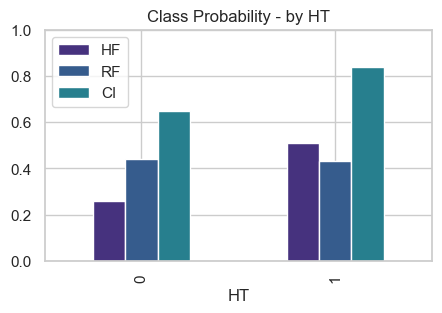

HF: 0.51 -> 0.59
RF: 0.43 -> 0.47
CI: 0.84 -> 0.89


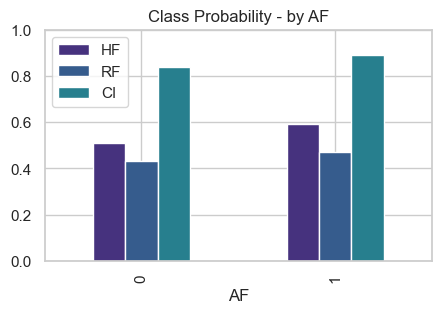

HF: 0.59 -> 0.82
RF: 0.47 -> 0.47
CI: 0.89 -> 0.9


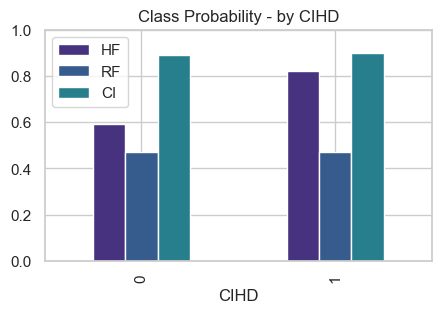

HF: 0.82 -> 0.83
RF: 0.47 -> 0.45
CI: 0.9 -> 0.65


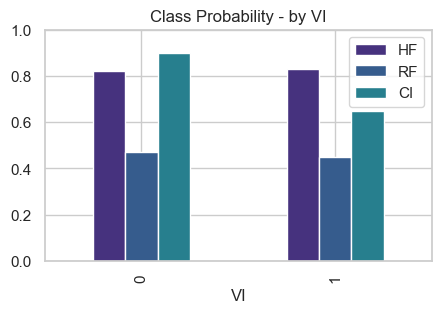

HF: 0.83 -> 0.83
RF: 0.45 -> 0.55
CI: 0.65 -> 0.64


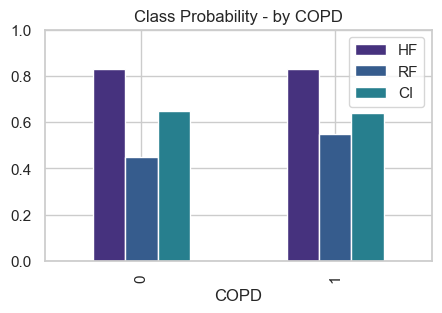

In [169]:
for feature in ['HT', 'AF', 'CIHD', 'VI', 'COPD']:
    plot_feature_importance(model, feature)

## Model - Feature Importance

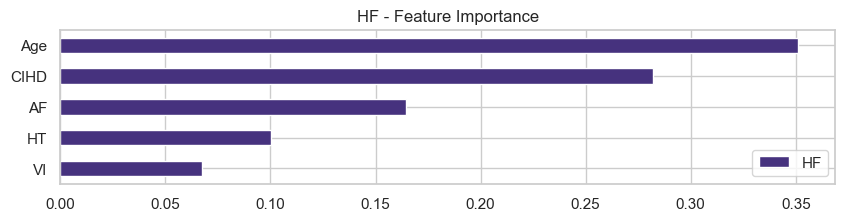

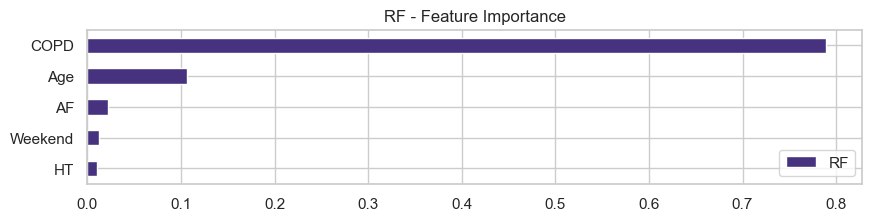

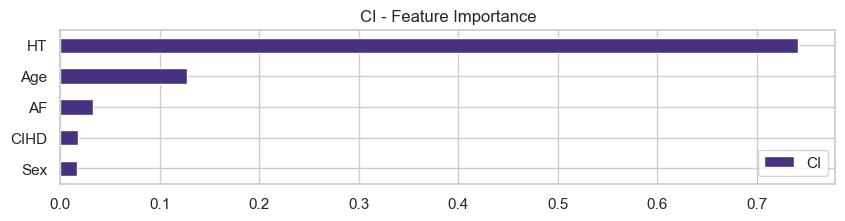

In [204]:
classifier = model.named_steps['Classifier']

inputs = ['Sex', 'Age', 'HT', 'AF', 'CIHD', 'COPD', 'VI', 'Max', 'Min', 'Prec', 'Press', 'Wind', 'Insolat', 'Weekend', 'Month', 'Holiday']
importances = [estimator.feature_importances_ for estimator in classifier.estimators_]
df_importances = pd.DataFrame({'Feature': inputs})
df_importances[target_columns] = np.transpose(importances)

for target in target_columns:
    df_importances.sort_values(target, ascending=False).head(5).sort_values(target, ascending=True)\
                    .plot(x='Feature', y=target, kind='barh', figsize=(10, 2), title=f'{target} - Feature Importance')
    plt.ylabel('')
    plt.show()
